In [1]:
import os
import gc

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from PIL import Image

from universal.data_loading import download_training_data, download_testing_data, get_trainval_dataset, \
    get_test_dataset, VOCDataset, test_transforms, train_transforms, classes, universal_transforms, normalize
from universal.deepfool import deepfool
from universal.plot import plot_images
from universal.universal_pert import universal_perturbation
from universal.vgg11_model import *
import logging
import torch
import torch.nn as nn
from torch.utils.data import RandomSampler, DataLoader, Subset
import argparse
import torchvision.models as models
import random

In [2]:
vgg11_layers = get_vgg_layers(vgg11_config, batch_norm=True)
OUTPUT_DIM = 20
device = 'cpu'
model = VGG(vgg11_layers, OUTPUT_DIM, device)

In [7]:
train_data_df, valid_data_df = get_trainval_dataset('.data/VOC2012')
# test_data_df = get_test_dataset(args.test_data)

train_data = VOCDataset(train_data_df, '.data/VOC2012', train_transforms)
valid_data = VOCDataset(valid_data_df, '.data/VOC2012', test_transforms)

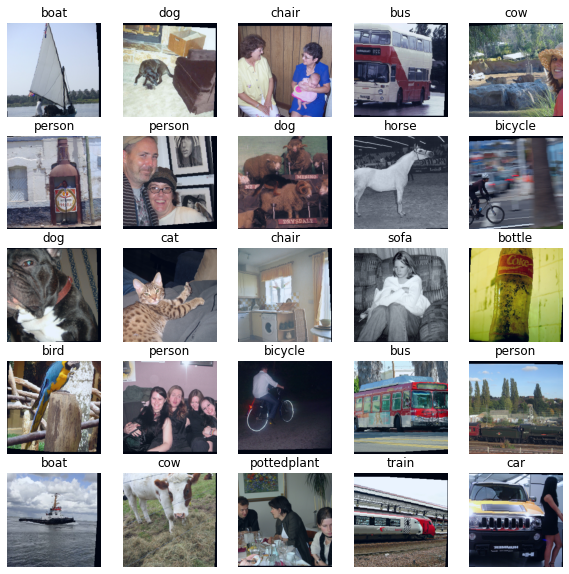

In [8]:
images, labels = zip(*[(image, label) for image, label in
                               [train_data[i] for i in random.sample(range(len(train_data)), 25)]])

plot_images(images, labels, classes)

In [9]:
model.load_state_dict(torch.load('vg11-voc2012-model.pt'))
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [10]:
def classifier(img):
    if img.ndim == 3:
        img = img.unsqueeze(0)
    img = normalize(img)
    v = model(img)[0]
    return v

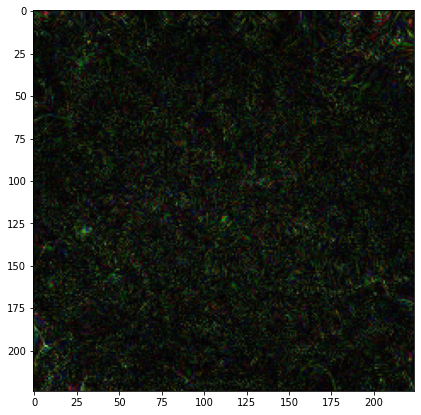

In [158]:
valid_data.transform = universal_transforms
v = np.load('_p.npy')
a = v.squeeze().transpose(1, 2, 0)

logging.info(f"Perturbation vector norm = {np.linalg.norm(abs(a))}")
a = np.abs(a)
perturbation = (a - np.min(a))/np.ptp(a)
plt.figure(figsize=(7, 7))
plt.imshow(perturbation)

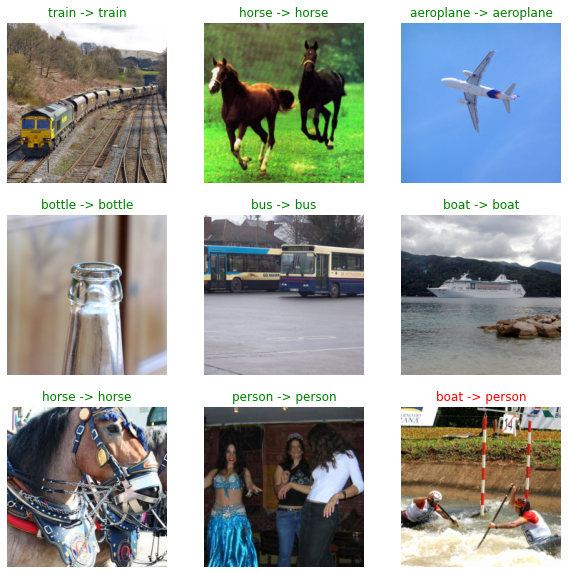

In [236]:
sample = random.sample(range(len(valid_data)), 10)
images, labels = zip(*[(image, label) for image, label in
                                   [valid_data[i] for i in sample]])
outputs = classifier(torch.stack(images).to(device))
predicted = outputs.argmax(dim=1)

plot_images(images, predicted, classes, true_labels=labels)

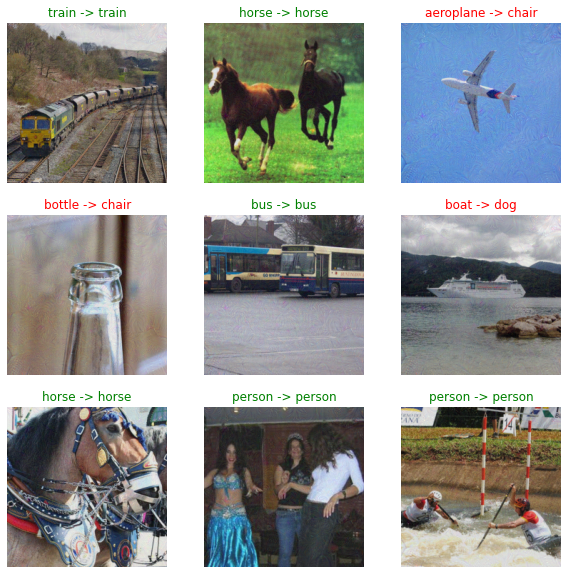

In [237]:
images, labels = zip(*[(image + v.squeeze(), label) for image, label in
                                   [valid_data[i] for i in sample]])

outputs = classifier(torch.stack(images).to(device))
predicted_perturbed = outputs.argmax(dim=1)

plot_images(images, predicted_perturbed, classes, true_labels=predicted)

In [238]:
count = 5
norms = np.linspace(0., 10000, count)
i = 5

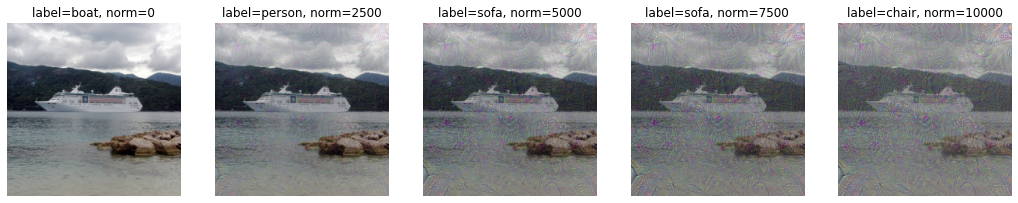

In [239]:
from universal.plot import normalize_image
img, label = valid_data[sample[i]]
imgs_perturbed = []
for norm in norms:
    norm = norm / 255
    normalized_v = v * (norm / np.linalg.norm(v))
    imgs_perturbed.append(img + normalized_v.squeeze())
    
outputs = model(torch.stack(imgs_perturbed).to(device))
_, predicted_perturbed = outputs[0].max(1)
fig, axs = plt.subplots(1, count, figsize=(18, 10))
for i, ax in enumerate(axs):
    ax.imshow(normalize_image(imgs_perturbed[i]).numpy().transpose(1, 2, 0))
    ax.set_title(f"label={classes[predicted_perturbed[i]]}, norm={int(norms[i])}")
    ax.set_axis_off()

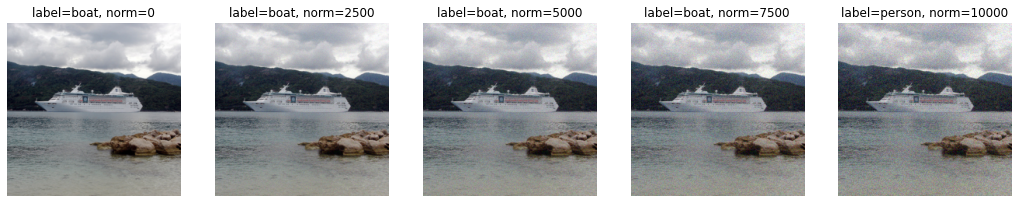

In [240]:
random_v =  np.random.rand(1, 3, 224, 224).astype(np.float32)
imgs_perturbed = []
for norm in norms:
    norm = norm / 255
    normalized_v = random_v * (norm / np.linalg.norm(random_v))
    imgs_perturbed.append(img + normalized_v.squeeze())
    
outputs = model(torch.stack(imgs_perturbed).to(device))
_, predicted_perturbed = outputs[0].max(1)
fig, axs = plt.subplots(1, count, figsize=(18, 10))
for i, ax in enumerate(axs):
    ax.imshow(normalize_image(imgs_perturbed[i]).numpy().transpose(1, 2, 0))
    ax.set_title(f"label={classes[predicted_perturbed[i]]}, norm={int(norms[i])}")
    ax.set_axis_off()

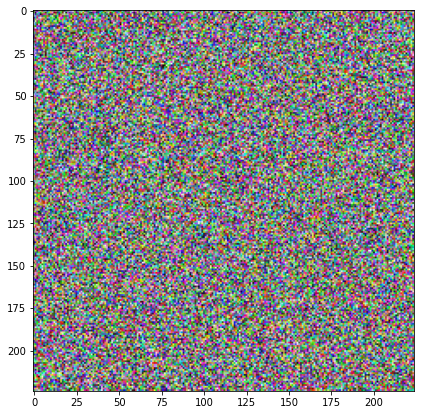

In [141]:
a = random_v.squeeze().transpose(1, 2, 0)

logging.info(f"Perturbation vector norm = {np.linalg.norm(abs(a))}")
a = np.abs(a)
perturbation = (a - np.min(a))/np.ptp(a)
plt.figure(figsize=(7, 7))
plt.imshow(perturbation)